In [1]:
from pathlib import Path
import numpy as np
from collections import defaultdict
import random

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------------------------------------
# Paths (adjust if your directory layout is different)
# ---------------------------------------------------------

SNIPPETS_PATH       = Path("../data/processed/snippets.npz")
AUTOENC_EMBED_PATH  = Path("../data/processed/autoencoder_embeddings.npz")
CONTRASTIVE_EMBED_PATH = Path("../data/processed/contrastive_embeddings.npz")


# ---------------------------------------------------------
# Data loading and splitting
# ---------------------------------------------------------

def load_snippets(snippets_path: Path = SNIPPETS_PATH):
    """
    Load snippet-level data from snippets.npz.

    Returns:
        intervals         : (N, L)
        durations         : (N, L)
        song_ids          : (N,)
        midi_filenames    : (N_songs,) or None
        genres            : (N,) or None
        snippet_labels    : (N,) or None
        start_secs        : (N,) or None
        end_secs          : (N,) or None
    """
    data = np.load(snippets_path, allow_pickle=True)
    intervals = data["intervals"]          # (N, L)
    durations = data["durations"]          # (N, L)
    song_ids  = data["song_ids"]           # (N,)
    midi_filenames = data.get("midi_filenames", None)

    genres = data.get("genres", None)
    snippet_labels = data.get("snippet_labels", None)
    start_secs = data.get("snippet_start_secs", None)
    end_secs = data.get("snippet_end_secs", None)

    return (
        intervals,
        durations,
        song_ids,
        midi_filenames,
        genres,
        snippet_labels,
        start_secs,
        end_secs,
    )


def load_embeddings(embed_path: Path):
    """
    Load snippet-level embeddings and minimal metadata.

    Returns:
        embeddings        : (N, H)
        song_ids          : (N,)
        midi_filenames    : (N_songs,) or None
        genres            : (N,) or None
        snippet_labels    : (N,) or None
        start_secs        : (N,) or None
        end_secs          : (N,) or None
    """
    data = np.load(embed_path, allow_pickle=True)
    embeddings = data["embeddings"]        # (N, H)
    song_ids   = data["song_ids"]          # (N,)
    midi_filenames = data.get("midi_filenames", None)

    genres = data.get("genres", None)
    snippet_labels = data.get("snippet_labels", None)
    start_secs = data.get("snippet_start_secs", None)
    end_secs = data.get("snippet_end_secs", None)

    return embeddings, song_ids, midi_filenames, genres, snippet_labels, start_secs, end_secs


def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three np.arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val   = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs   = unique_songs[n_train:n_train + n_val]
    test_songs  = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx   = idx_for(val_songs)
    test_idx  = idx_for(test_songs)

    return train_idx, val_idx, test_idx


# ---------------------------------------------------------
# Baseline: edit distance on interval sequences
# ---------------------------------------------------------

def levenshtein_distance(seq1, seq2):
    """
    Basic Levenshtein edit distance between two 1D integer sequences.
    Complexity O(L^2)
    """
    len1, len2 = len(seq1), len(seq2)
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    for i in range(len1 + 1):
        dp[i][0] = i
    for j in range(len2 + 1):
        dp[0][j] = j

    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,          # deletion
                dp[i][j - 1] + 1,          # insertion
                dp[i - 1][j - 1] + cost,   # substitution
            )
    return dp[len1][len2]

def precision_at_k_baseline(
    intervals,
    song_ids,
    test_idx,
    ks=(5, 10),
    max_queries=200,
    seed=0
):
    """
    Evaluate baseline edit-distance retrieval on test snippets.

    For each query in a subset of test_idx, find nearest neighbors among test_idx.
    Compute Precision@K: fraction of neighbors sharing the same song_id.
    """
    rng = np.random.default_rng(seed)
    test_idx = np.array(test_idx)
    N_test = len(test_idx)

    if N_test == 0:
        raise ValueError("Test set is empty.")

    if max_queries is not None and max_queries < N_test:
        query_indices = rng.choice(test_idx, size=max_queries, replace=False)
    else:
        query_indices = test_idx

    ks = sorted(ks)
    prec_sums = {k: 0.0 for k in ks}
    num_queries = len(query_indices)

    print(f"[Baseline] Evaluating on {num_queries} test queries...")

    for count, qi in enumerate(query_indices, start=1):
        q_seq = intervals[qi]
        # distances to all other test snippets
        dists = []
        for tj in test_idx:
            if tj == qi:
                dists.append(np.inf)
            else:
                d = levenshtein_distance(q_seq, intervals[tj])
                dists.append(d)
        dists = np.array(dists)
        # sort by distance (smallest = most similar)
        sorted_idx_local = np.argsort(dists)

        # map back to global snippet indices
        neighbors = test_idx[sorted_idx_local]

        for k in ks:
            topk = neighbors[:k]
            hits = (song_ids[topk] == song_ids[qi]).sum()
            prec_sums[k] += hits / k

        if count % 20 == 0 or count == num_queries:
            print(f"  Processed {count}/{num_queries} queries", end="\r")

    print()

    prec_at_k = {k: prec_sums[k] / num_queries for k in ks}
    return prec_at_k

# ---------------------------------------------------------
# Embedding-based retrieval and metrics
# ---------------------------------------------------------

def cosine_sim_matrix(embeddings, query_vec):
    """
    embeddings: (N, H)
    query_vec: (H,)
    returns: (N,) cosine similarities
    """
    emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    q_norm   = query_vec / np.linalg.norm(query_vec)
    return emb_norm @ q_norm


def precision_at_k_embeddings(
    embeddings,
    song_ids,
    test_idx,
    ks=(5, 10),
    max_queries=500,
    seed=0
):
    """
    Evaluate embedding-based retrieval with cosine similarity on test snippets.
    """
    rng = np.random.default_rng(seed)
    test_idx = np.array(test_idx)
    N_test = len(test_idx)

    if N_test == 0:
        raise ValueError("Test set is empty.")

    if max_queries is not None and max_queries < N_test:
        query_indices = rng.choice(test_idx, size=max_queries, replace=False)
    else:
        query_indices = test_idx

    ks = sorted(ks)
    prec_sums = {k: 0.0 for k in ks}
    num_queries = len(query_indices)

    print(f"[Embeddings] Evaluating on {num_queries} test queries...")

    # Pre-normalize embeddings for speed
    emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    for count, qi in enumerate(query_indices, start=1):
        q_emb = emb_norm[qi]
        sims = emb_norm[test_idx] @ q_emb  # similarities only within test set

        # set similarity with itself to -inf so it never appears in neighbors
        self_pos = np.where(test_idx == qi)[0]
        if len(self_pos) == 1:
            sims[self_pos[0]] = -np.inf

        sorted_idx_local = np.argsort(-sims)  # descending similarity
        neighbors = test_idx[sorted_idx_local]

        for k in ks:
            topk = neighbors[:k]
            hits = (song_ids[topk] == song_ids[qi]).sum()
            prec_sums[k] += hits / k

        if count % 50 == 0 or count == num_queries:
            print(f"  Processed {count}/{num_queries} queries", end="\r")

    print()

    prec_at_k = {k: prec_sums[k] / num_queries for k in ks}
    return prec_at_k


# ---------------------------------------------------------
# Retrieval demo helpers
# ---------------------------------------------------------


def demo_retrieval_baseline(
    query_idx,
    intervals,
    song_ids,
    midi_filenames=None,
    genres=None,
    snippet_labels=None,
    start_secs=None,
    end_secs=None,
    top_k=5,
):
    print(f"=== BASELINE RETRIEVAL DEMO FOR QUERY {query_idx} ===")
    sid = int(song_ids[query_idx])
    print(f"song_id={sid}")
    if genres is not None:
        print(f"genre={genres[query_idx]}")
    if midi_filenames is not None and sid < len(midi_filenames):
        print("file:", midi_filenames[sid])
    if snippet_labels is not None:
        print("label:", snippet_labels[query_idx])
    if start_secs is not None and end_secs is not None:
        print(f"time: {start_secs[query_idx]:.2f}s → {end_secs[query_idx]:.2f}s")

    dists = []
    N = intervals.shape[0]
    q_seq = intervals[query_idx]
    for j in range(N):
        if j == query_idx:
            dists.append(np.inf)
        else:
            d = levenshtein_distance(q_seq, intervals[j])
            dists.append(d)
    dists = np.array(dists)
    nn_idx = np.argsort(dists)[:top_k]

    print("\n[Baseline] Nearest neighbors by edit distance:")
    for j in nn_idx:
        sid_j = int(song_ids[j])
        fname = midi_filenames[sid_j] if midi_filenames is not None and sid_j < len(midi_filenames) else "N/A"
        g = genres[j] if genres is not None else "?"
        label = snippet_labels[j] if snippet_labels is not None else ""
        print(f"  idx={j:4d}, song_id={sid_j}, genre={g}, file={fname}, dist={dists[j]:.1f}")
        if label:
            print(f"       label: {label}")
        if start_secs is not None and end_secs is not None:
            print(f"       time: {start_secs[j]:.2f}s → {end_secs[j]:.2f}s")



def demo_retrieval_embeddings(
    method_name,
    query_idx,
    embeddings,
    song_ids,
    midi_filenames=None,
    genres=None,
    snippet_labels=None,
    start_secs=None,
    end_secs=None,
    top_k=5,
):
    print(f"=== {method_name.upper()} RETRIEVAL DEMO FOR QUERY {query_idx} ===")
    sid = int(song_ids[query_idx])
    print(f"song_id={sid}")
    if genres is not None:
        print(f"genre={genres[query_idx]}")
    if midi_filenames is not None and sid < len(midi_filenames):
        print("file:", midi_filenames[sid])
    if snippet_labels is not None:
        print("label:", snippet_labels[query_idx])
    if start_secs is not None and end_secs is not None:
        print(f"time: {start_secs[query_idx]:.2f}s → {end_secs[query_idx]:.2f}s")

    sims = cosine_sim_matrix(embeddings, embeddings[query_idx])
    sims[query_idx] = -np.inf
    nn_idx = np.argsort(-sims)[:top_k]

    print(f"\n[{method_name}] Nearest neighbors by embedding cosine similarity:")
    for j in nn_idx:
        sid_j = int(song_ids[j])
        fname = midi_filenames[sid_j] if midi_filenames is not None and sid_j < len(midi_filenames) else "N/A"
        g = genres[j] if genres is not None else "?"
        label = snippet_labels[j] if snippet_labels is not None else ""
        print(f"  idx={j:4d}, song_id={sid_j}, genre={g}, file={fname}, sim={sims[j]:.3f}")
        if label:
            print(f"       label: {label}")
        if start_secs is not None and end_secs is not None:
            print(f"       time: {start_secs[j]:.2f}s → {end_secs[j]:.2f}s")


# ---------------------------------------------------------
# Visualization: PCA of embeddings
# ---------------------------------------------------------


def plot_pca_embeddings(embeddings_dict, genres, num_points=1000, seed=0):
    """
    embeddings_dict: dict name -> (N, D) arrays
    genres         : (N,) array of snippet genres
    Plots PCA for each embedding set in a separate figure,
    colored by genre (if available).
    """
    rng = np.random.default_rng(seed)
    N = genres.shape[0]
    if num_points is not None and num_points < N:
        idx = rng.choice(np.arange(N), size=num_points, replace=False)
    else:
        idx = np.arange(N)

    genres_sample = genres[idx] if genres is not None else np.array(["unknown"] * len(idx))

    unique_genres = np.unique(genres_sample)
    genre_to_color = {g: i for i, g in enumerate(unique_genres)}
    colors = np.array([genre_to_color[g] for g in genres_sample])

    for name, emb in embeddings_dict.items():
        emb_sample = emb[idx]

        pca = PCA(n_components=2)
        coords = pca.fit_transform(emb_sample)

        plt.figure(figsize=(7, 6))
        sc = plt.scatter(coords[:, 0], coords[:, 1],
                         c=colors, s=8, alpha=0.7, cmap="tab20")
        handles, _ = sc.legend_elements(num=len(unique_genres))
        plt.legend(handles, unique_genres, title="Genre",
                   bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.title(f"PCA of {name} embeddings (colored by genre)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()


In [2]:
# ---------------------------------------------------------
# Main entry point
# ---------------------------------------------------------
print("Loading snippets...")
(intervals,
 durations,
 song_ids_snip,
 midi_filenames_snip,
 genres_snip,
 snippet_labels_snip,
 start_secs_snip,
 end_secs_snip) = load_snippets()

print("Loading autoencoder embeddings...")
(autoemb,
 song_ids_auto,
 midi_files_auto,
 genres_auto,
 labels_auto,
 start_secs_auto,
 end_secs_auto) = load_embeddings(AUTOENC_EMBED_PATH)

print("Loading contrastive embeddings...")
(contremb,
 song_ids_contra,
 midi_files_contra,
 genres_contra,
 labels_contra,
 start_secs_contra,
 end_secs_contra) = load_embeddings(CONTRASTIVE_EMBED_PATH)

# Sanity checks
assert intervals.shape[0] == autoemb.shape[0] == contremb.shape[0], \
    "Snippets and embeddings must have same number of rows!"
assert np.array_equal(song_ids_snip, song_ids_auto) and np.array_equal(song_ids_snip, song_ids_contra), \
    "song_ids must match across snippets and embedding files."

song_ids = song_ids_snip
midi_filenames = midi_filenames_snip
genres = genres_snip
snippet_labels = snippet_labels_snip
start_secs = start_secs_snip
end_secs = end_secs_snip

train_idx, val_idx, test_idx = split_by_song(song_ids)
print(f"Total snippets: {len(song_ids)}")
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
print()

Loading snippets...
Loading autoencoder embeddings...
Loading contrastive embeddings...
Total snippets: 34513
Train: 24131, Val: 5089, Test: 5293



In [3]:
# ----- Baseline evaluation -----
baseline_prec = precision_at_k_baseline(
    intervals=intervals,
    song_ids=song_ids,
    test_idx=test_idx,
    ks=(5, 10),
    max_queries=200,
)
print("Baseline Precision@K (edit distance on intervals):")
for k, v in baseline_prec.items():
    print(f"  P@{k} = {v:.4f}")
print()

[Baseline] Evaluating on 200 test queries...
  Processed 200/200 queries
Baseline Precision@K (edit distance on intervals):
  P@5 = 0.4330
  P@10 = 0.3120



In [4]:
# ----- Autoencoder embedding evaluation -----
auto_prec = precision_at_k_embeddings(
    embeddings=autoemb,
    song_ids=song_ids,
    test_idx=test_idx,
    ks=(5, 10),
    max_queries=500,
)
print("Autoencoder Embedding Precision@K (cosine similarity):")
for k, v in auto_prec.items():
    print(f"  P@{k} = {v:.4f}")
print()

[Embeddings] Evaluating on 500 test queries...
  Processed 500/500 queries
Autoencoder Embedding Precision@K (cosine similarity):
  P@5 = 0.3624
  P@10 = 0.2864



In [5]:
# ----- Contrastive embedding evaluation -----
contra_prec = precision_at_k_embeddings(
    embeddings=contremb,
    song_ids=song_ids,
    test_idx=test_idx,
    ks=(5, 10),
    max_queries=500,
)
print("Contrastive Embedding Precision@K (cosine similarity):")
for k, v in contra_prec.items():
    print(f"  P@{k} = {v:.4f}")
print()

[Embeddings] Evaluating on 500 test queries...
  Processed 500/500 queries
Contrastive Embedding Precision@K (cosine similarity):
  P@5 = 0.3512
  P@10 = 0.2940



In [6]:
def precision_at_k_random(song_ids, test_idx, ks=(5, 10), max_queries=500, seed=0):
    rng = np.random.default_rng(seed)
    test_idx = np.array(test_idx)
    N_test = len(test_idx)

    if max_queries is not None and max_queries < N_test:
        query_indices = rng.choice(test_idx, size=max_queries, replace=False)
    else:
        query_indices = test_idx

    ks = sorted(ks)
    prec_sums = {k: 0.0 for k in ks}
    num_queries = len(query_indices)

    print(f"[Random] Evaluating on {num_queries} test queries...")

    for count, qi in enumerate(query_indices, start=1):
        # choose random neighbors from test set (excluding itself)
        pool = test_idx[test_idx != qi]
        for k in ks:
            neighbors = rng.choice(pool, size=k, replace=False)
            hits = (song_ids[neighbors] == song_ids[qi]).sum()
            prec_sums[k] += hits / k

        if count % 50 == 0 or count == num_queries:
            print(f"  Processed {count}/{num_queries} queries", end="\r")

    print()
    return {k: prec_sums[k] / num_queries for k in ks}

rand_prec = precision_at_k_random(song_ids, test_idx, ks=(5,10))
print("Random baseline:")
for k,v in rand_prec.items():
    print(f"  P@{k} = {v:.4f}")

[Random] Evaluating on 500 test queries...
  Processed 500/500 queries
Random baseline:
  P@5 = 0.0092
  P@10 = 0.0086


=== Summary (Precision@K on test songs) ===
Model                    P@5      P@10
----------------------------------------
Baseline (edit dist)   0.4330  0.3120
Autoencoder embeddings 0.3624  0.2864
Contrastive embeddings 0.3512  0.2940

--- Retrieval demos on a random test snippet ---
=== BASELINE RETRIEVAL DEMO FOR QUERY 9985 ===
song_id=275
genre=folk
file: Amusttoa.mid
label: folk_Amusttoa_idx000064_to000096_t0007.35s_to0011.31s
time: 7.35s → 11.31s

[Baseline] Nearest neighbors by edit distance:
  idx=10002, song_id=275, genre=folk, file=Amusttoa.mid, dist=6.0
       label: folk_Amusttoa_idx000336_to000368_t0039.22s_to0042.82s
       time: 39.22s → 42.82s
  idx=10037, song_id=275, genre=folk, file=Amusttoa.mid, dist=12.0
       label: folk_Amusttoa_idx000896_to000928_t0104.22s_to0108.08s
       time: 104.22s → 108.08s
  idx=10019, song_id=275, genre=folk, file=Amusttoa.mid, dist=12.0
       label: folk_Amusttoa_idx000608_to000640_t0070.69s_to0074.56s
       time: 70.69s → 74.56s


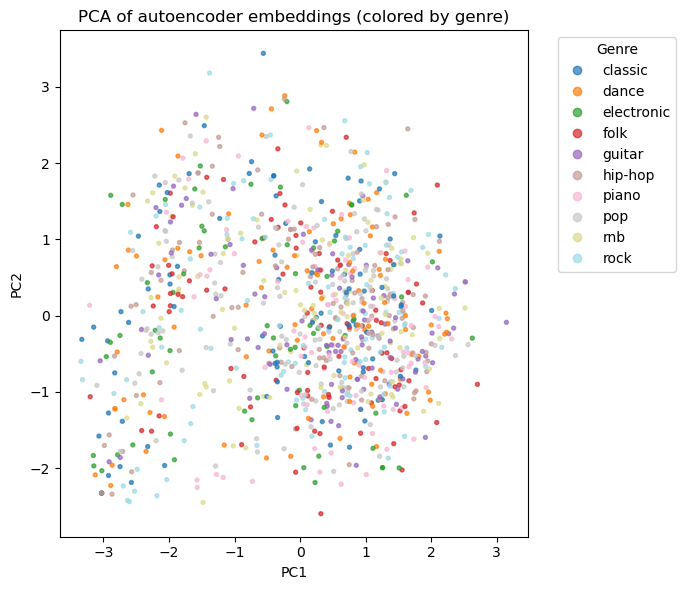

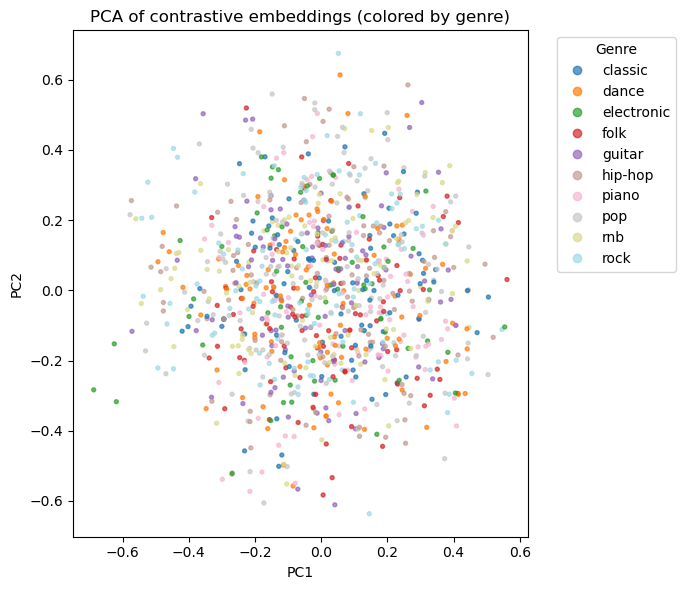

In [7]:
# ----- Summary table -----
print("=== Summary (Precision@K on test songs) ===")
print("Model                    P@5      P@10")
print("----------------------------------------")
print(f"Baseline (edit dist)   {baseline_prec[5]:.4f}  {baseline_prec[10]:.4f}")
print(f"Autoencoder embeddings {auto_prec[5]:.4f}  {auto_prec[10]:.4f}")
print(f"Contrastive embeddings {contra_prec[5]:.4f}  {contra_prec[10]:.4f}")
print()

# ----- Retrieval demos -----
print("--- Retrieval demos on a random test snippet ---")
query = random.choice(test_idx.tolist())
demo_retrieval_baseline(
    query_idx=query,
    intervals=intervals,
    song_ids=song_ids,
    midi_filenames=midi_filenames,
    genres=genres,
    snippet_labels=snippet_labels,
    start_secs=start_secs,
    end_secs=end_secs,
    top_k=5,
)
print()
demo_retrieval_embeddings(
    method_name="autoencoder",
    query_idx=query,
    embeddings=autoemb,
    song_ids=song_ids,
    midi_filenames=midi_filenames,
    genres=genres,
    snippet_labels=snippet_labels,
    start_secs=start_secs,
    end_secs=end_secs,
    top_k=5,
)
print()
demo_retrieval_embeddings(
    method_name="contrastive",
    query_idx=query,
    embeddings=contremb,
    song_ids=song_ids,
    midi_filenames=midi_filenames,
    genres=genres,
    snippet_labels=snippet_labels,
    start_secs=start_secs,
    end_secs=end_secs,
    top_k=5,
)

# ----- PCA plots -----
print("\nPlotting PCA for autoencoder and contrastive embeddings...")
emb_dict = {
    "autoencoder": autoemb,
    "contrastive": contremb,
}
plot_pca_embeddings(emb_dict, genres, num_points=1000)